# <p><center style="font-family:newtimeroman;font-size:180%;"> Brain Tumors Variety Classification and Quality Evaluation Using Image Analysis </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Train VGG16 Model](#4)
* [Evaluate The Model](#5)

**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [7]:
from PIL import Image
import os
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                                     BatchNormalization, Flatten, Dense, Dropout)
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import warnings

In [8]:
#Files
path='/Users/gamalielmarines/Downloads/Data 2'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0  meningioma_tumor
1      glioma_tumor
2   pituitary_tumor
3            normal

In [9]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)

# Set split ratios for train, validation, and test
train_split = 0.7  # 70% for training
val_split = 0.15   # 15% for validation
test_split = 0.15  # 15% for test

# Train set
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=(1 - train_split),  # 30% reserved for validation+test
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

# Validation and Test set (split from the remaining 30%)
validation = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=val_split / (val_split + test_split),  # 50% of the remaining 30% (i.e., 15%)
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=val_split / (val_split + test_split),  # 50% of the remaining 30% (i.e., 15%)
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

Found 3096 files belonging to 4 classes.
Using 2168 files for training.
Found 3096 files belonging to 4 classes.
Using 1548 files for validation.
Found 3096 files belonging to 4 classes.
Using 1548 files for validation.


In [10]:
class_names = train.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


2024-11-13 16:13:16.478598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-13 16:13:17.276898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-13 16:13:18.011519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-13 16:13:18.709683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-13 16:13:19.111220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-13 16:13:19.523879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


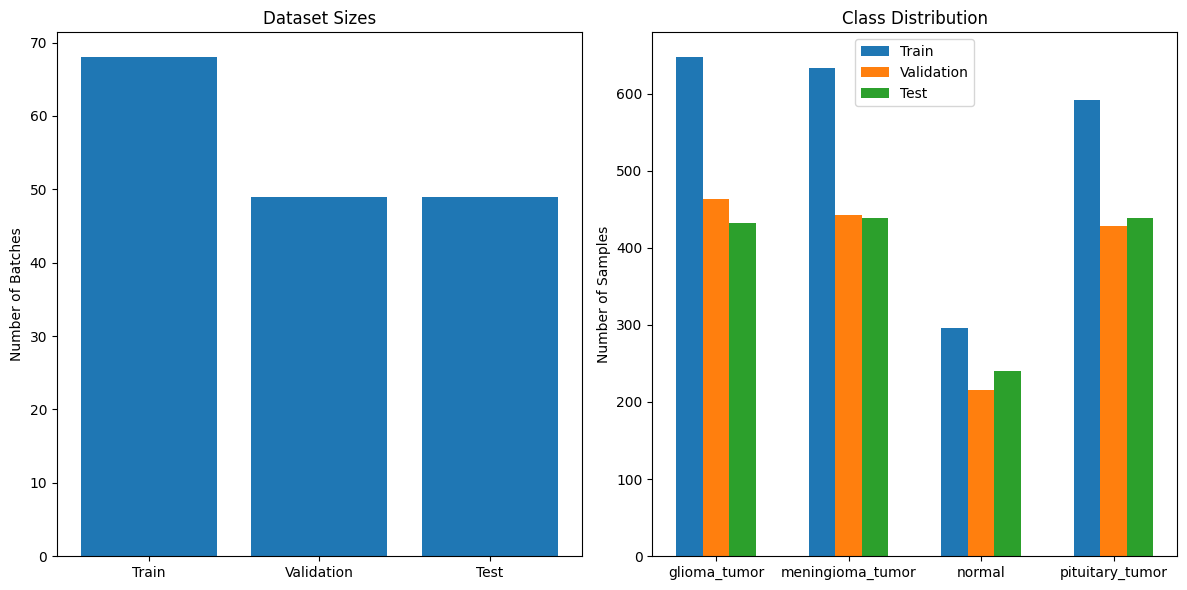

In [11]:
# Get the sizes of the datasets
train_size = len(list(train))
val_size = len(list(validation))
test_size = len(list(test))

# Get the class distribution in each dataset
train_class_counts = np.zeros(len(class_names))
val_class_counts = np.zeros(len(class_names))
test_class_counts = np.zeros(len(class_names))

for images, labels in train:
    for label in labels.numpy():
        train_class_counts[label] += 1

for images, labels in validation:
    for label in labels.numpy():
        val_class_counts[label] += 1

for images, labels in test:
    for label in labels.numpy():
        test_class_counts[label] += 1

# Plot the sizes of the datasets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(['Train', 'Validation', 'Test'], [train_size, val_size, test_size])
plt.title('Dataset Sizes')
plt.ylabel('Number of Batches')

# Plot the class distribution in each dataset
x = np.arange(len(class_names))
width = 0.2

plt.subplot(1, 2, 2)
plt.bar(x - width, train_class_counts, width, label='Train')
plt.bar(x, val_class_counts, width, label='Validation')
plt.bar(x + width, test_class_counts, width, label='Test')
plt.xticks(x, class_names)
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.legend()

plt.tight_layout()
plt.show()

2024-11-13 16:13:20.457446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


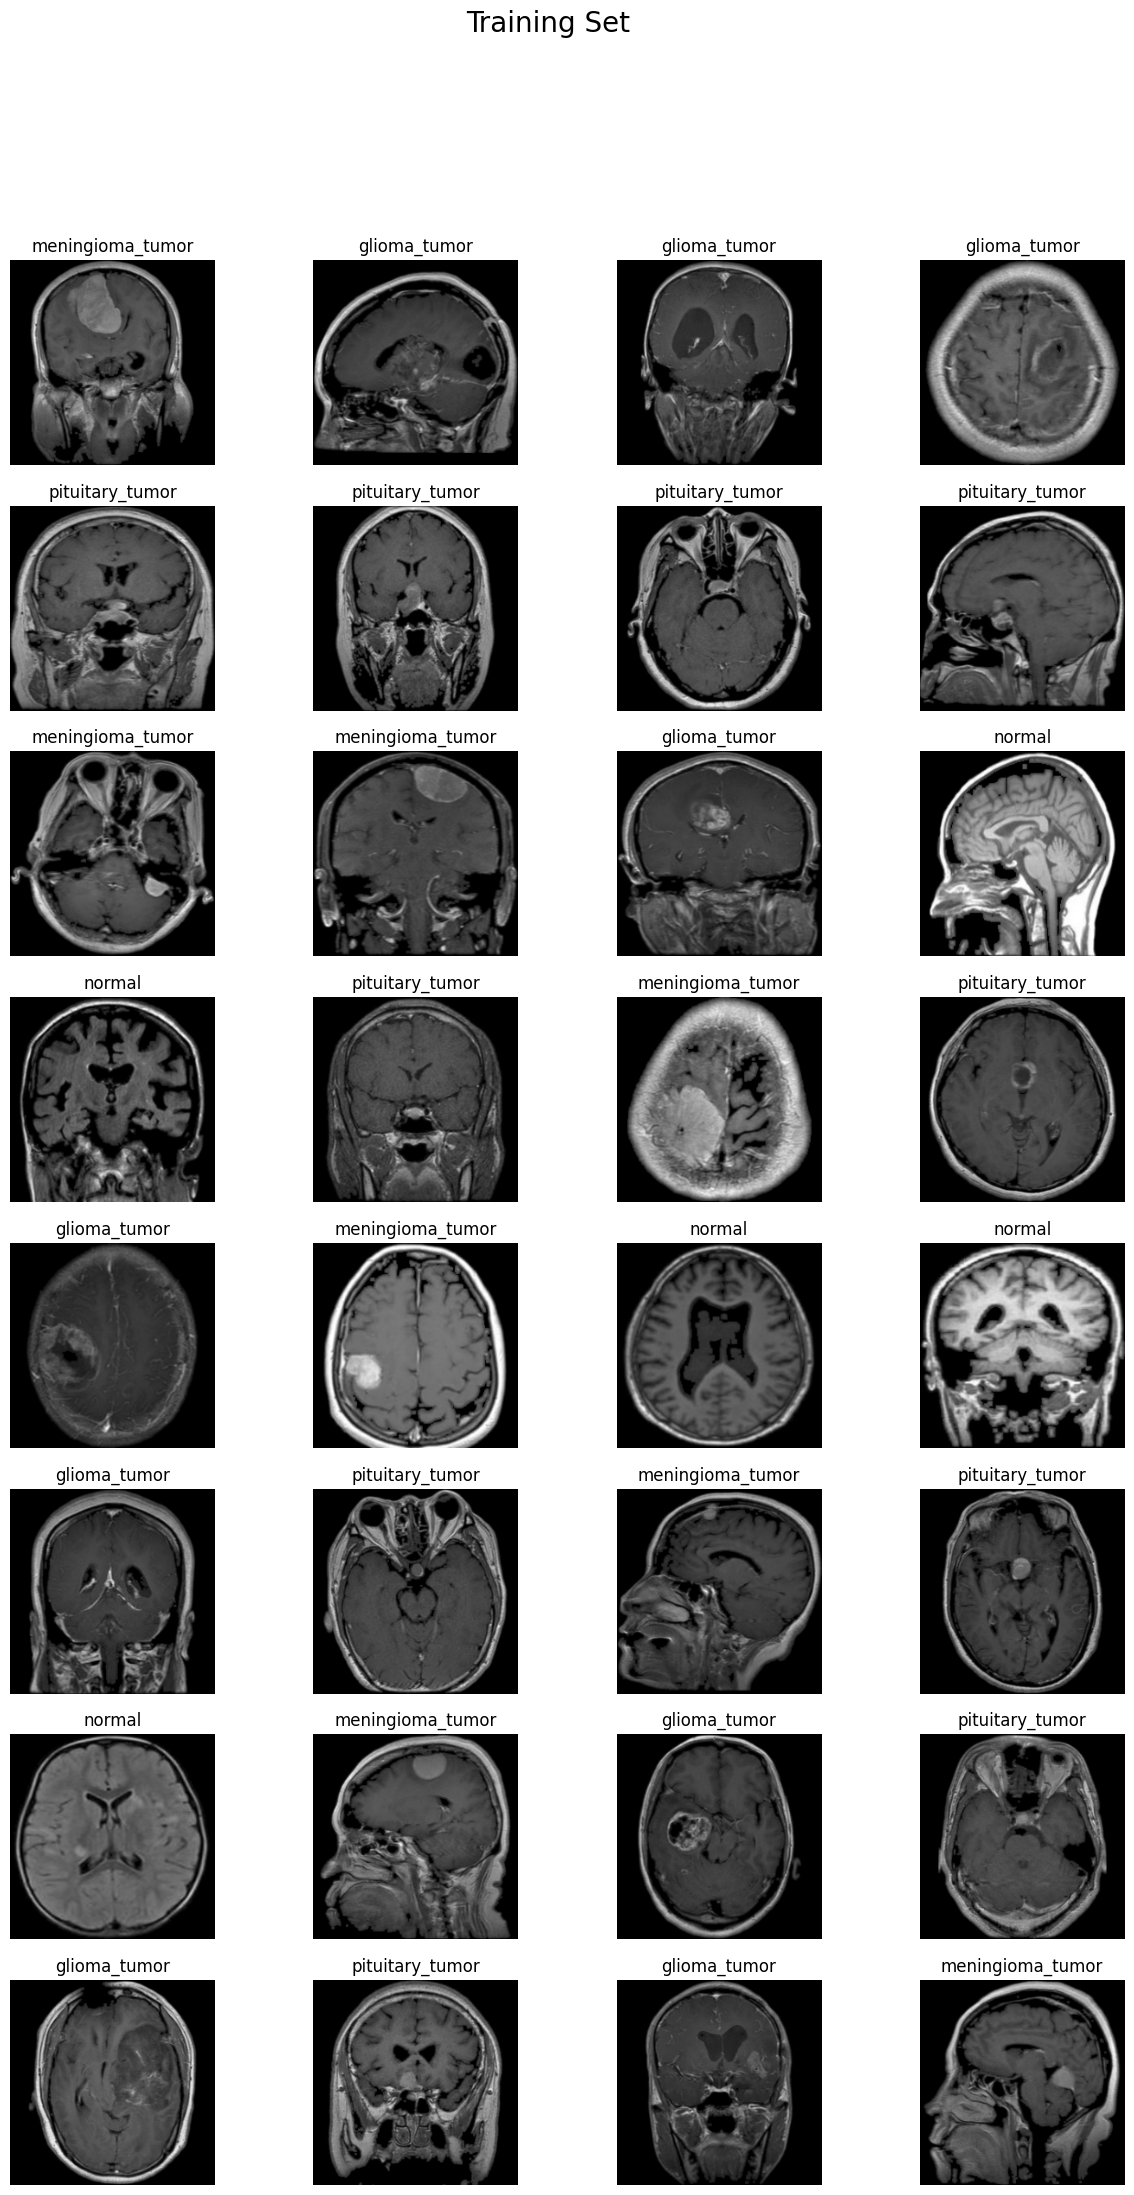

2024-11-13 16:13:23.666068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


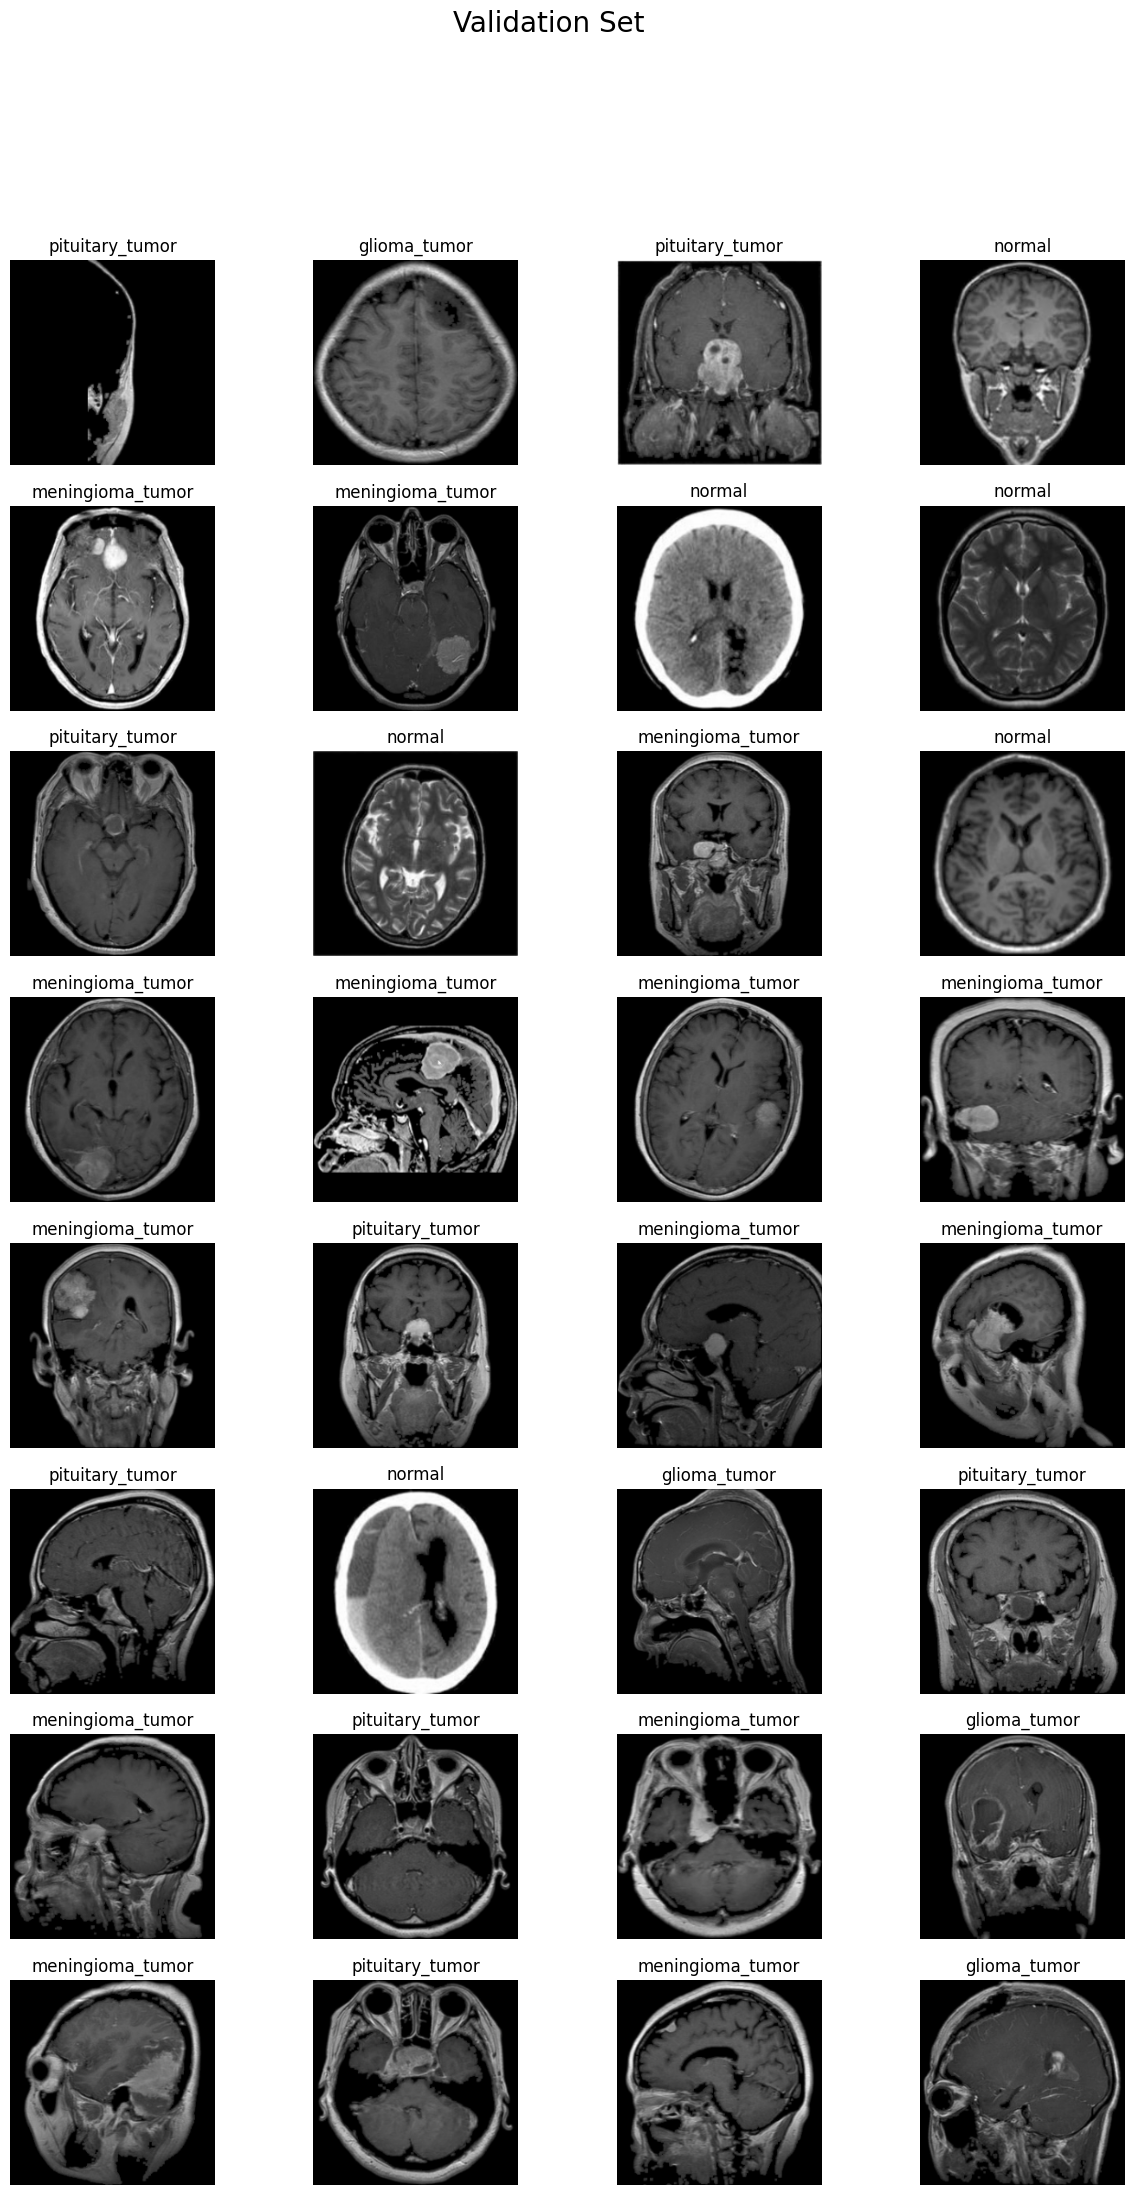

2024-11-13 16:13:26.671088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


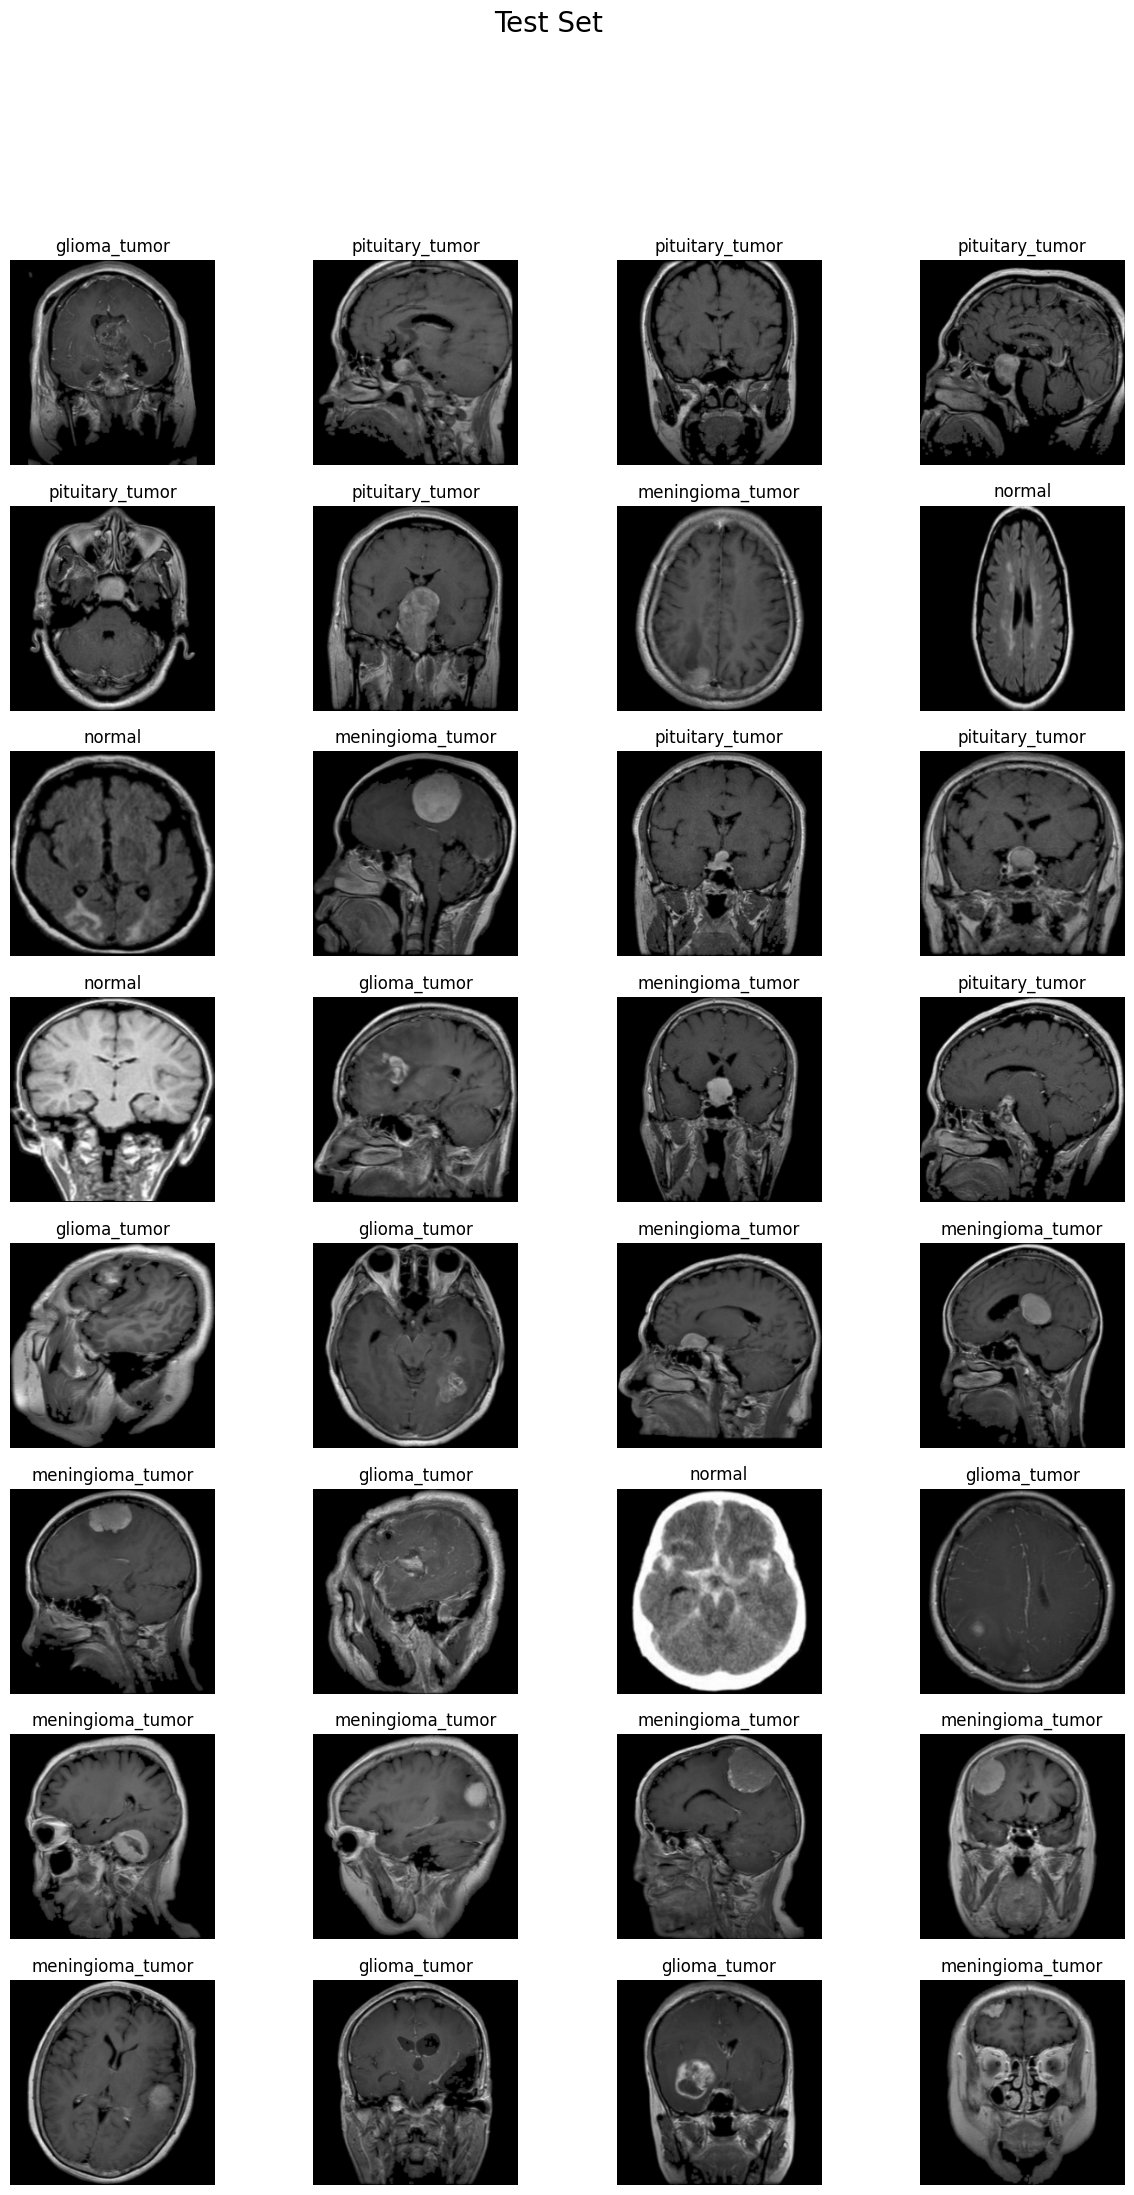

In [12]:
def plot_dataset(dataset, title):
    plt.figure(figsize=(15, 25))
    for images, labels in dataset.take(1):
        for i in range(32):
            ax = plt.subplot(8, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle(title, fontsize=20)
    plt.show()

# Plot training set
plot_dataset(train, "Training Set")

# Plot validation set
plot_dataset(validation, "Validation Set")

# Plot test set
plot_dataset(test, "Test Set")

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [13]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow import keras

# Load the ResNet50 base model with ImageNet weights, excluding the top layers
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='/Users/gamalielmarines/Desktop/reto benji/ResNet50 Weights.h5'  # Using ImageNet weights
)

# Freeze the base model layers to prevent them from training
base_model.trainable = False

# Build the complete model by stacking additional layers
model = keras.models.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')  # Adjust this number to match your specific number of classes
])

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Build the model by calling it on a sample batch of data (to initialize shapes)
model.build((None, 224, 224, 3))

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       401,412 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 401,412 (1.53 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
checkpoint_cb = ModelCheckpoint("my_keras_model2.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=[checkpoint_cb]
)


Epoch 1/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.5712 - loss: 9.1957 - val_accuracy: 0.9121 - val_loss: 0.7305
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.9046 - loss: 0.8699 - val_accuracy: 0.9225 - val_loss: 0.9213
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.9016 - loss: 1.2524 - val_accuracy: 0.9251 - val_loss: 1.1521
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.9525 - loss: 0.5323 - val_accuracy: 0.9451 - val_loss: 0.7444
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.9741 - loss: 0.1698 - val_accuracy: 0.9438 - val_loss: 0.7955
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.9776 - loss: 0.2394 - val_accuracy: 0.9587 - val_loss: 0.6138
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9767 - loss: 0.1900 - val_accuracy: 0.9457 - val_loss: 0.9178
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 994s 15s/step - accuracy: 0.9742 - loss: 0.2990 - val_accuracy: 0.9645 - 

In [16]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

49/49 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9466 - loss: 1.0319
Test Loss = 1.0745387077331543
Test Accuracy = 0.9528423547744751


In [17]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.722786  5.097656      0.912145  0.730544
1   0.908210  0.815411      0.922481  0.921318
2   0.904059  1.073112      0.925065  1.152099
3   0.949262  0.543625      0.945090  0.744405
4   0.975554  0.179063      0.943798  0.795499
5   0.972786  0.284550      0.958656  0.613794
6   0.973247  0.237248      0.945736  0.917787
7   0.974170  0.310628      0.964470  0.568365
8   0.983856  0.104228      0.952196  0.803827
9   0.976015  0.290876      0.960594  0.838031
10  0.982934  0.153145      0.961886  0.750827
11  0.980627  0.248166      0.964470  0.786208
12  0.987546  0.134602      0.963178  0.801036
13  0.987546  0.139165      0.958010  1.165344
14  0.980166  0.187405      0.952842  1.074539

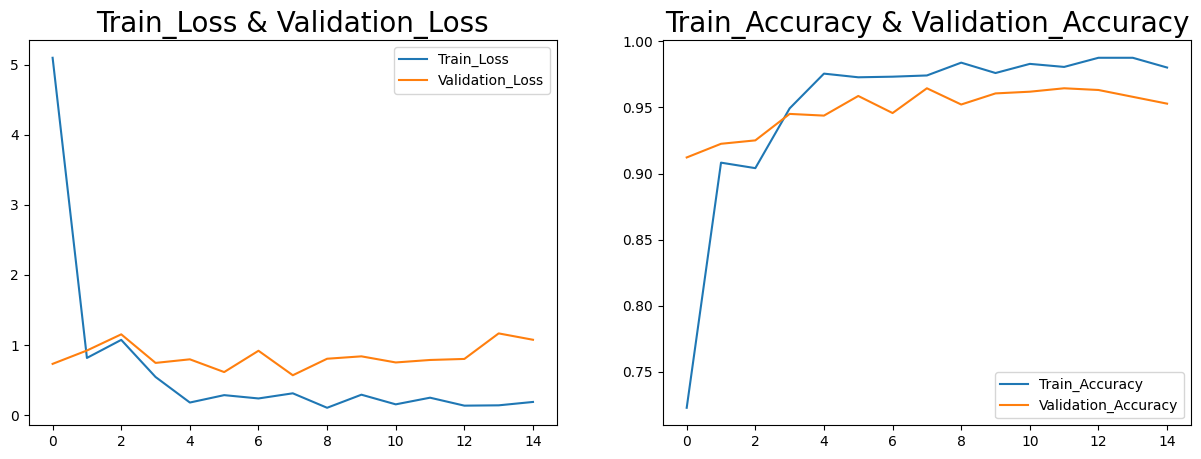

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [19]:
X_val,y_val,y_pred=[],[],[]
for images, labels in test:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

2024-11-13 17:51:16.019361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


49/49 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step


Actual  Prediction
0          2           2
1          3           3
2          2           2
3          1           1
4          1           1
...      ...         ...
1543       2           2
1544       0           0
1545       3           3
1546       0           0
1547       2           2

[1548 rows x 2 columns]

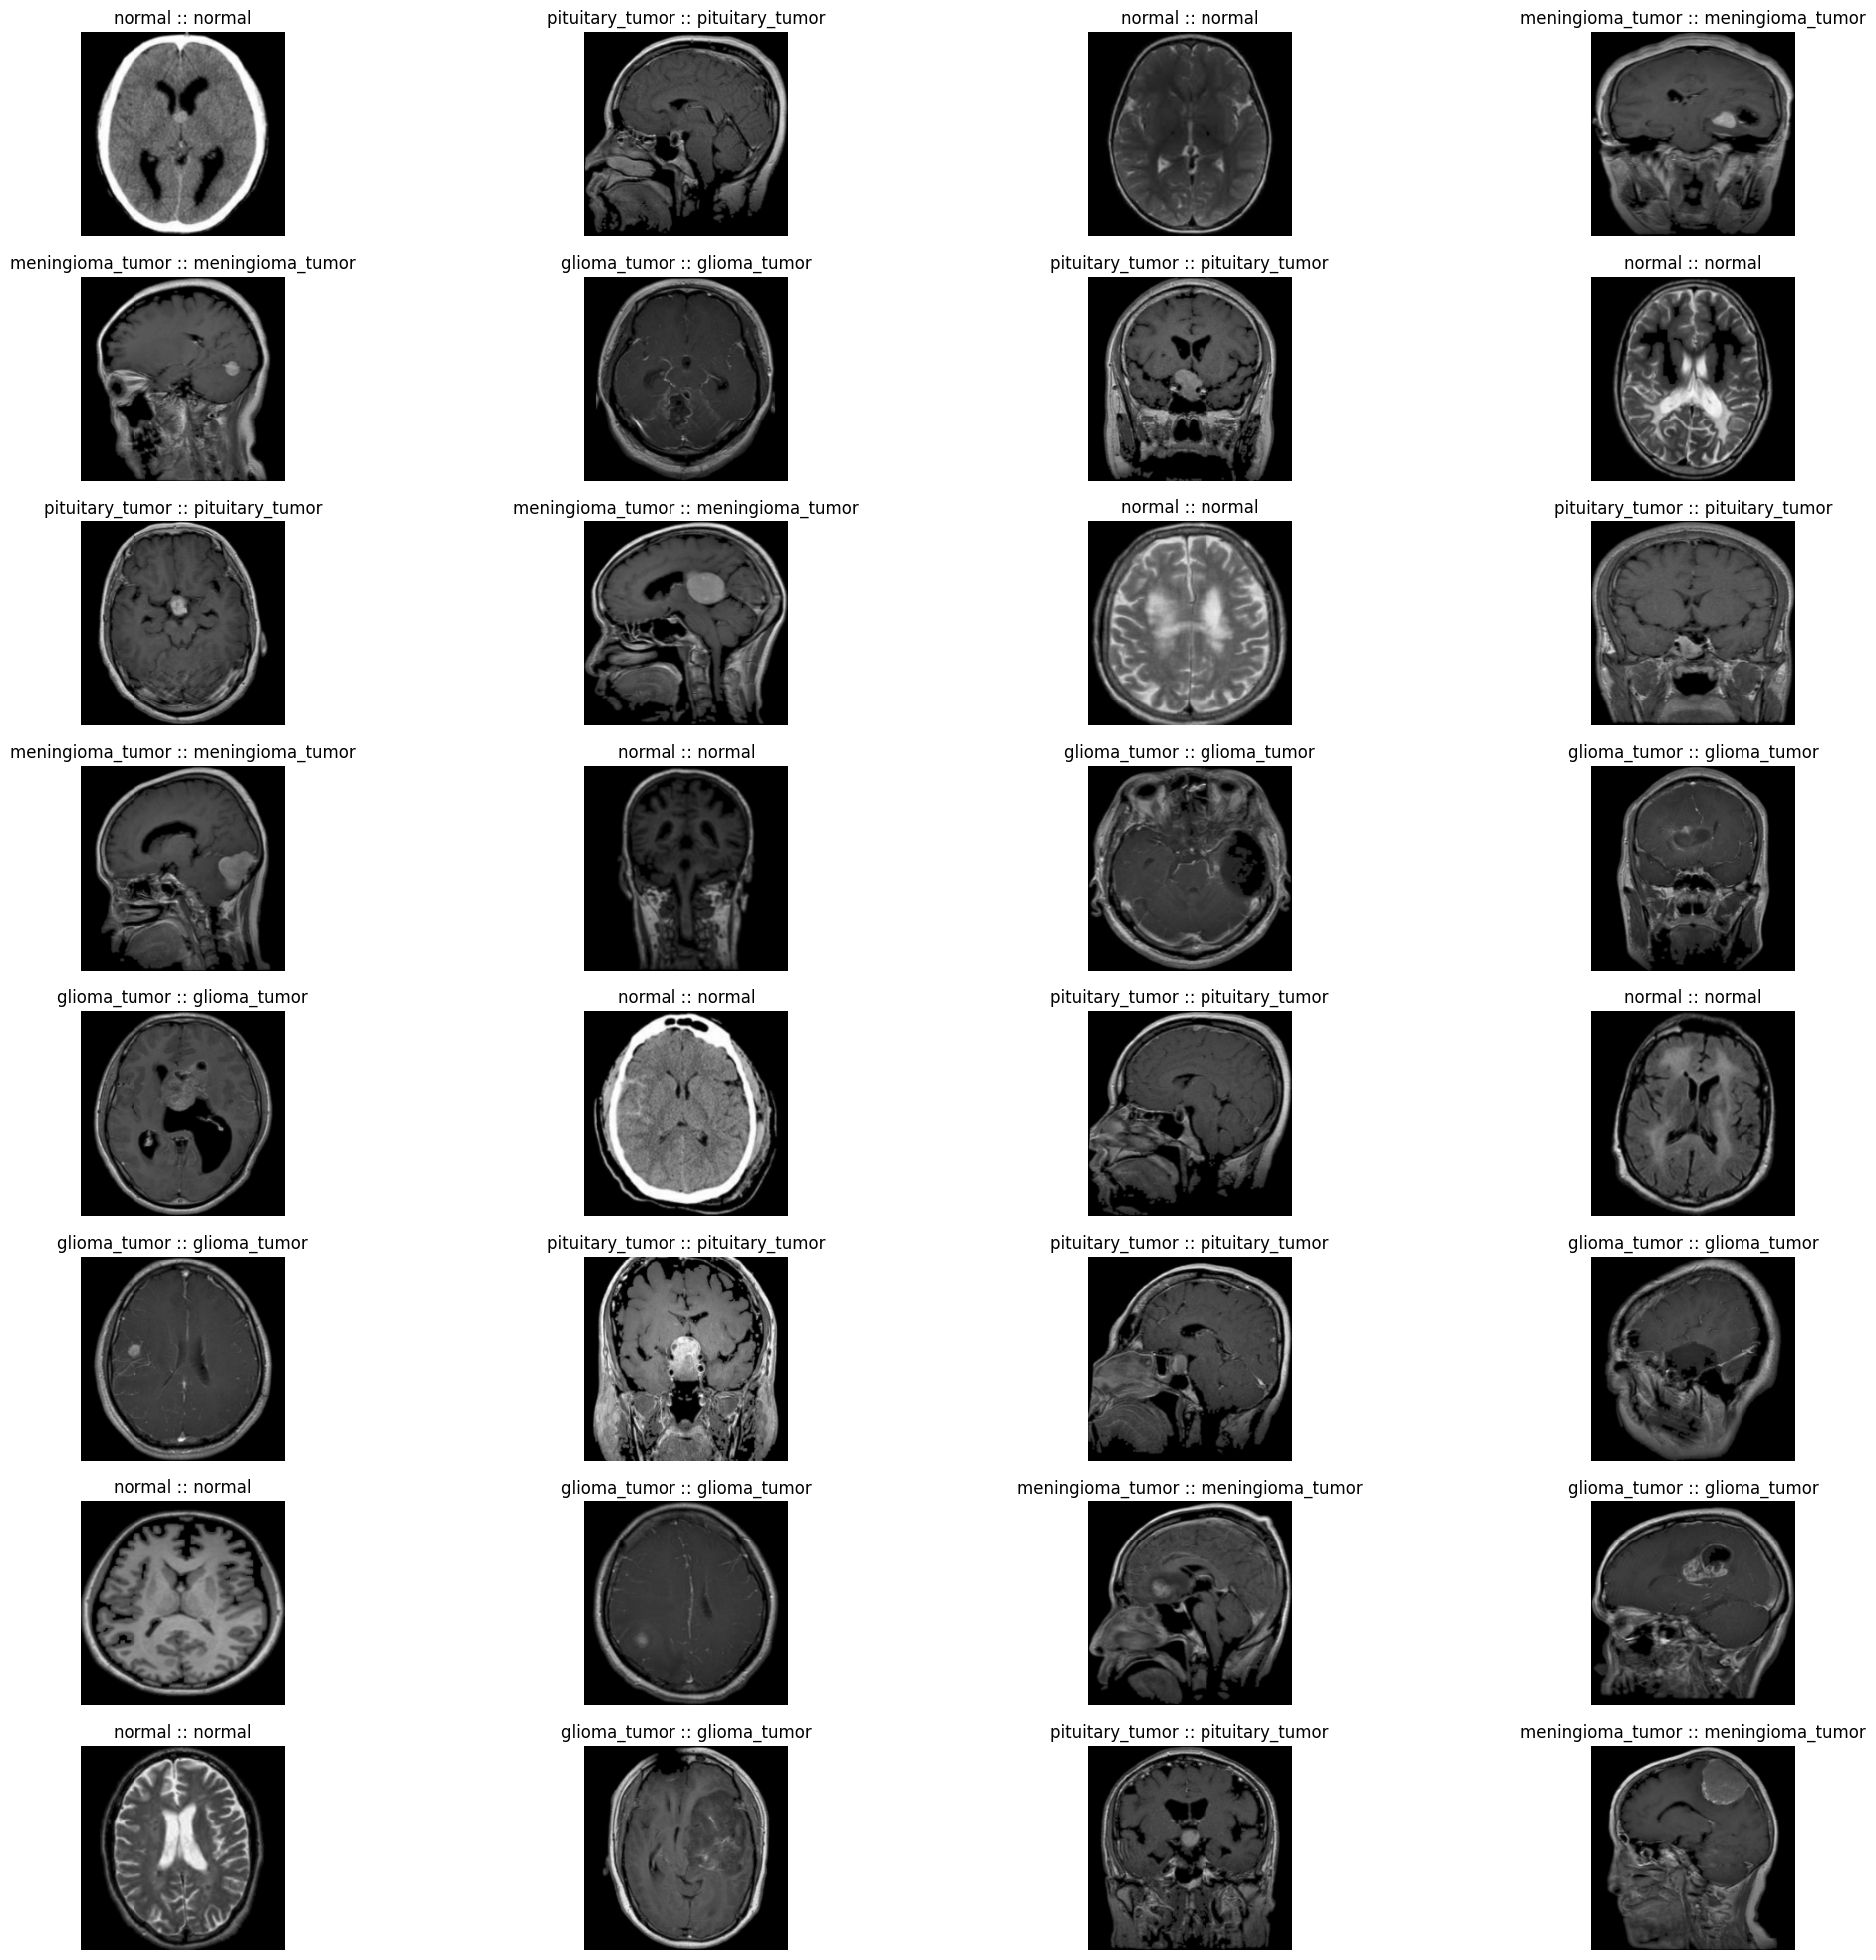

In [20]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

<a id="5"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

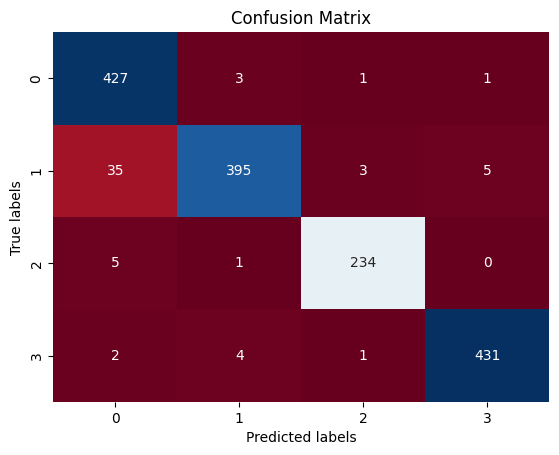

array([[427,   3,   1,   1],
       [ 35, 395,   3,   5],
       [  5,   1, 234,   0],
       [  2,   4,   1, 431]])

In [21]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [22]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.91      0.99      0.95       432
           1       0.98      0.90      0.94       438
           2       0.98      0.97      0.98       240
           3       0.99      0.98      0.99       438

    accuracy                           0.96      1548
   macro avg       0.96      0.96      0.96      1548
weighted avg       0.96      0.96      0.96      1548



In [23]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_images_from_folder(model, folder_path, target_size=(224, 224)):

    # List to store predictions
    predictions = []

    # Iterate over all files in the folder
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image

        # Make prediction
        pred = model.predict(img_array)
        pred_class = np.argmax(pred, axis=1)
        predictions.append((img_name, pred_class[0]))

    return predictions

# Example usage
folder_path = '/Users/gamalielmarines/Desktop/reto benji/img_predictions'
predictions = predict_images_from_folder(model, folder_path)
for img_name, pred_class in predictions:
    print(f"Image: {img_name}, Predicted Class: {class_names[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Image: nomral_brain2.jpeg, Predicted Class: normal
Image: normal_brain1.jpeg, Predicted Class: normal
Image: Normal Brain MRI.png, Predicted Class: normal
Image: Normal Brain MRI (1).png, Predicted Class: normal


In [24]:
import tkinter as tk
from tkinter import filedialog, Label
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to predict the selected image
def predict_single_image(model, img_path, target_size=(224, 224)):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)
    return pred_class[0]

# Define class names for predictions
class_names = ['glimona tumor', 'meningioma tumor', 'normal', 'pituitary tumor']  # Replace with your actual class names

# Create tkinter window for selecting image and displaying prediction
def open_image():
    # Open file dialog to select image
    img_path = filedialog.askopenfilename()
    if img_path:
        # Display selected image in tkinter window
        img = Image.open(img_path)
        img = img.resize((224, 224))
        img_tk = ImageTk.PhotoImage(img)
        img_label.config(image=img_tk)
        img_label.image = img_tk

        # Predict the class using the model
        pred_class = predict_single_image(model, img_path)
        result_label.config(text=f"Predicted Class: {class_names[pred_class]}")

# Set up the tkinter GUI
root = tk.Tk()
root.title("Brain MRI Prediction")
root.geometry("300x400")

# Create and place labels for image and prediction result
img_label = Label(root)
img_label.pack(pady=20)

result_label = Label(root, text="Select an image to predict", font=("Arial", 14))
result_label.pack(pady=10)

# Button to select image
button = tk.Button(root, text="Select Image", command=open_image)
button.pack(pady=20)

root.mainloop()


2024-11-13 17:53:01.584 Python[2332:11726] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
